<a href="https://colab.research.google.com/github/JasonKilembe/Certificats/blob/master/SelectivityNet_Colab_Ready.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# SelectivityNet — **Google Colab** Notebook (ECFP4, RF/XGB/DNN + SelectNet‑lite)

This Colab notebook installs a **compatible stack** (fixes `_ARRAY_API`), then:
1) Loads & cleans your dataset (IC₅₀ nM → pIC₅₀)  
2) Plots dataset statistics (Figure 1 panels)  
3) Trains **RF**, **XGB**, **DNN**, and **SelectivityNet‑lite** (ECFP4 only)  
4) Aggregates **R² / RMSE** into **Table 2** and comparative plots  

> Expected CSV columns: `canonical_smiles, target_name, standard_value, standard_units`


In [1]:
# CLEAN OUT troublemakers that drag NumPy 2.x API
%pip uninstall -y -q numpy jax jaxlib tensorflow tensorflow-text keras ml-dtypes

# Install a compatible set (works with RDKit wheels)
%pip install -q --no-cache-dir --upgrade pip
%pip install -q --no-cache-dir "numpy==1.26.4" "scipy==1.11.4" "scikit-learn==1.4.2" \
                               "xgboost==1.7.6" "rdkit-pypi==2022.9.5" pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.76 requires ml_dtypes>=0.5.0, which is not installed.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, which is not installed.
chex 0.1.90 requires jax>=0.4.27, which is not installed.
chex 0.1.90 requires jaxlib>=0.4.27, which is not installed.
dopamine-rl 4.1.2 requires jax>=0.1.72, which is not installed.
dopamine-rl 4.1.2 requires jaxlib>=0.1.51, which is not installed.
dopamine-rl 4.1.2 requires tensorflow>=2.2.0, which is not installed.
orbax-checkpoint 0.11.21 requires jax>=0.5.0, which is not installed.
optax 0.2.5 requires jax>=0.4.27, which is not installed.
optax 0.2.5 requires jaxlib>=0.4.27, which is not installed.
keras-hub 0.21.1 requires keras>=3.5, which is not installed.
keras-hub 0.21.1 re

In [1]:
# Sanity: versions + where NumPy comes from
import numpy, scipy, sklearn, xgboost, rdkit, sys
print("numpy:", numpy.__version__, numpy.__file__)
print("scipy:", scipy.__version__)
print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
print("rdkit:", rdkit.__version__)

numpy: 1.26.4 /usr/local/lib/python3.11/dist-packages/numpy/__init__.py
scipy: 1.11.4
scikit-learn: 1.4.2
xgboost: 1.7.6
rdkit: 2022.09.5


In [2]:
!pip install -q --upgrade pip
!pip install -q "numpy==1.26.4" "scipy==1.11.4" "scikit-learn==1.4.2" \
               "xgboost==1.7.6" "rdkit-pypi==2022.9.5" pandas matplotlib

In [3]:
import numpy, scipy, sklearn, xgboost, rdkit
print("numpy:", numpy.__version__)          # 1.26.4
print("scipy:", scipy.__version__)          # 1.11.x
print("scikit-learn:", sklearn.__version__) # 1.4.x
print("xgboost:", xgboost.__version__)      # 1.7.x
print("rdkit:", rdkit.__version__)          # 2022.9.x

numpy: 1.26.4
scipy: 1.11.4
scikit-learn: 1.4.2
xgboost: 1.7.6
rdkit: 2022.09.5


In [4]:

# Run this AFTER restarting the runtime.
import numpy, scipy, sklearn, xgboost, pandas, matplotlib, rdkit
from rdkit import Chem
print("numpy:", numpy.__version__)
print("scipy:", scipy.__version__)
print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
print("pandas:", pandas.__version__)
print("matplotlib:", matplotlib.__version__)
print("rdkit:", rdkit.__version__)
m = Chem.MolFromSmiles("CCO")
print("RDKit OK?", m is not None)


numpy: 1.26.4
scipy: 1.11.4
scikit-learn: 1.4.2
xgboost: 1.7.6
pandas: 2.2.2
matplotlib: 3.10.0
rdkit: 2022.09.5
RDKit OK? True


### (Optional) Mount Google Drive to read/save files

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
# You can set INPUT_CSV to a path under /content/drive/MyDrive/...


KeyboardInterrupt: 

In [11]:

from pathlib import Path
INPUT_CSV = "/content/dataset_with_pIC50.csv"  # <-- CHANGE to your file path
OUTDIR = Path("/content/ijms_outputs"); OUTDIR.mkdir(parents=True, exist_ok=True)
FIG = OUTDIR / "figures"; FIG.mkdir(exist_ok=True)
ART = OUTDIR / "artifacts"; ART.mkdir(exist_ok=True)
CHUNKSIZE = 50000
print("Output directory:", OUTDIR)


Output directory: /content/ijms_outputs


In [12]:

import json, warnings, numpy as np, pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from sklearn.metrics import r2_score, mean_squared_error
warnings.filterwarnings("ignore")

def load_and_clean_chunked(csv_path: str, chunksize: int = 50000) -> pd.DataFrame:
    usecols = ["canonical_smiles", "target_name", "standard_value", "standard_units"]
    recs = []
    try:
        it = pd.read_csv(csv_path, usecols=usecols, chunksize=chunksize)
    except Exception:
        it = pd.read_csv(csv_path, usecols=usecols, chunksize=chunksize, engine="python")
    for chunk in it:
        c = chunk.dropna(subset=usecols).copy()
        c = c[c["standard_units"].astype(str).str.lower()=="nm"]
        c["standard_value"] = pd.to_numeric(c["standard_value"], errors="coerce")
        c = c.dropna(subset=["standard_value"])
        c["pIC50"] = 9 - np.log10(c["standard_value"].astype(float))
        c = c[(c["pIC50"]>3) & (c["pIC50"]<12)].copy()
        c = c.rename(columns={"canonical_smiles":"smiles"})
        c = c[["smiles","target_name","pIC50"]]
        recs.append(c)
    if not recs:
        return pd.DataFrame(columns=["smiles","target_name","pIC50"])
    df = pd.concat(recs, ignore_index=True)
    df = df.drop_duplicates(subset=["smiles","target_name"])
    return df

def dataset_statistics(df: pd.DataFrame) -> pd.DataFrame:
    g = df.groupby("target_name")
    stats = g.agg(
        n_compounds=("smiles","nunique"),
        n_measurements=("smiles","count"),
        pIC50_min=("pIC50","min"),
        pIC50_max=("pIC50","max"),
        pIC50_mean=("pIC50","mean"),
        pIC50_std=("pIC50","std"),
    ).reset_index()
    for c in ["pIC50_min","pIC50_max","pIC50_mean","pIC50_std"]:
        stats[c] = stats[c].round(2)
    return stats

def hash_bucket(text: str, n_buckets=10) -> int:
    return abs(hash(text)) % n_buckets

def split_by_hash(df: pd.DataFrame):
    df = df.copy()
    df["bucket"] = df["smiles"].apply(hash_bucket)
    train = df[df["bucket"].isin([0,1,2,3,4,5,6])].copy()
    val   = df[df["bucket"]==7].copy()
    test  = df[df["bucket"].isin([8,9])].copy()
    return train, val, test

def ecfp4_from_smiles_list(smiles_list, n_bits=2048, radius=2):
    fps = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            fps.append(np.zeros(n_bits, dtype=np.int8)); continue
        bv = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        arr = np.zeros((n_bits,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(bv, arr)
        fps.append(arr)
    return np.array(fps, dtype=np.int8)

def metrics(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    r2   = float(r2_score(y_true, y_pred))
    return {"rmse": rmse, "r2": r2}


In [13]:

df = load_and_clean_chunked(INPUT_CSV, chunksize=CHUNKSIZE)
df.to_csv(ART/"cleaned_dataset.csv", index=False)
print("Rows after cleaning:", len(df))
stats_table = dataset_statistics(df)
stats_table.to_csv(ART/"table1_dataset_stats.csv", index=False)
stats_table.head()


Rows after cleaning: 34027


,target_name,n_compounds,n_measurements,pIC50_min,pIC50_max,pIC50_mean,pIC50_std
0,AR,3143,3143,3.31,10.50,6.35,1.24
1,EGFR,10771,10771,3.05,11.52,6.48,1.44
2,HIF1A,310,310,4.00,9.33,5.54,1.03
3,TOP2A,3250,3250,3.30,9.85,6.30,1.13
4,VEGFR2,11471,11471,3.08,10.70,6.46,1.28


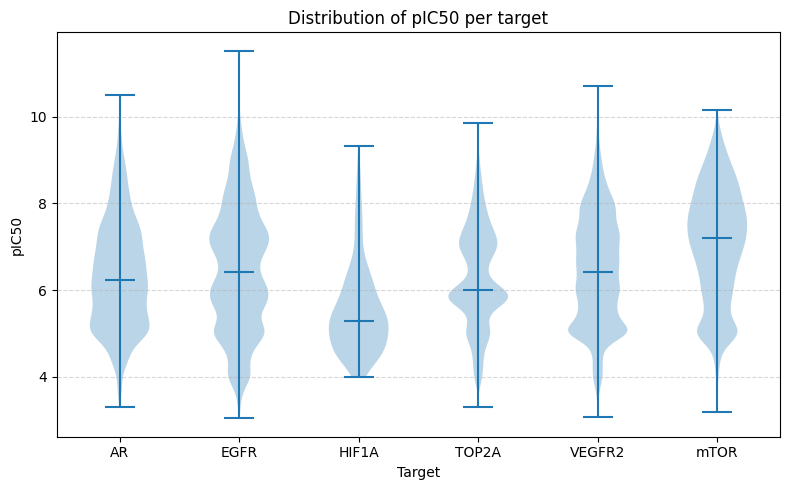

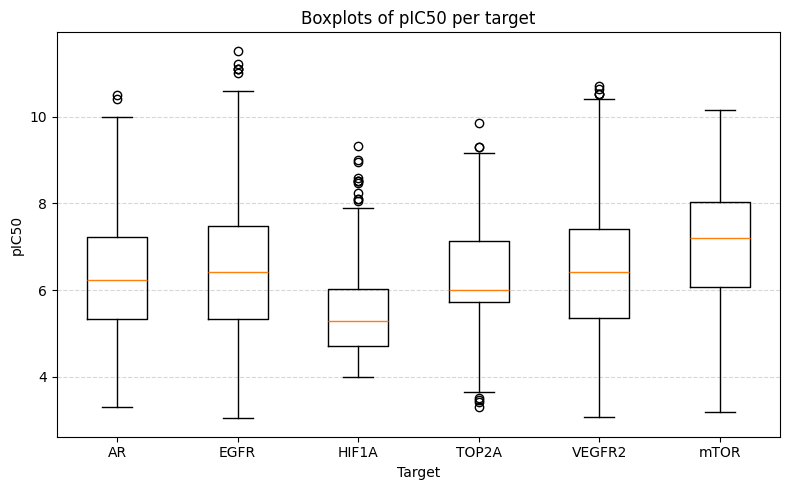

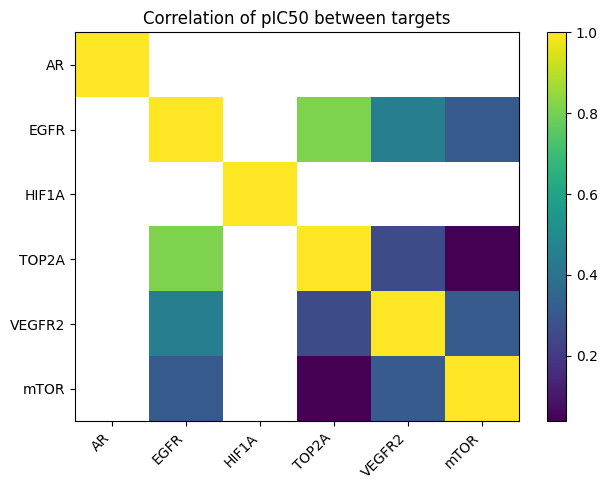

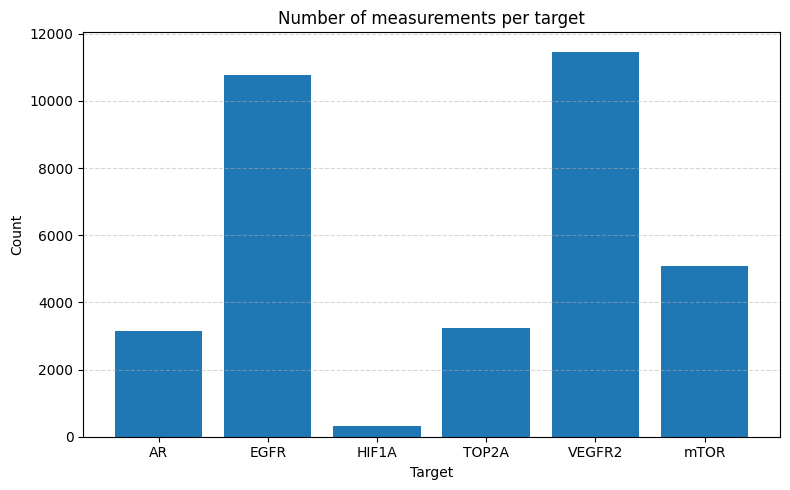

In [14]:

import matplotlib.pyplot as plt
targets = stats_table["target_name"].tolist()

# Fig 1a - violin
plt.figure(figsize=(8,5))
data_violin = [df[df["target_name"]==t]["pIC50"].values for t in targets]
plt.violinplot(data_violin, showmedians=True, showextrema=True)
plt.xticks(ticks=range(1, len(targets)+1), labels=targets, rotation=0)
plt.title("Distribution of pIC50 per target"); plt.xlabel("Target"); plt.ylabel("pIC50")
plt.grid(axis="y", linestyle="--", alpha=0.5); plt.tight_layout()
plt.savefig(FIG/"Fig1a_violin.png", dpi=300); plt.show()

# Fig 1b - boxplot
plt.figure(figsize=(8,5))
plt.boxplot([df[df["target_name"]==t]["pIC50"].values for t in targets], labels=targets, showfliers=True)
plt.title("Boxplots of pIC50 per target"); plt.xlabel("Target"); plt.ylabel("pIC50")
plt.grid(axis="y", linestyle="--", alpha=0.5); plt.tight_layout()
plt.savefig(FIG/"Fig1b_boxplot.png", dpi=300); plt.show()

# Fig 1c - corr heatmap
pivot = df.pivot_table(index="smiles", columns="target_name", values="pIC50")
corr = pivot.corr(min_periods=5)
plt.figure(figsize=(6.5,5))
plt.imshow(corr, aspect="auto"); plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation of pIC50 between targets"); plt.tight_layout()
plt.savefig(FIG/"Fig1c_correlation.png", dpi=300); plt.show()

# Fig 1d - counts
counts = df.groupby("target_name")["smiles"].count().reindex(targets)
plt.figure(figsize=(8,5))
plt.bar(range(len(counts)), counts.values)
plt.xticks(range(len(counts)), counts.index, rotation=0)
plt.title("Number of measurements per target"); plt.xlabel("Target"); plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.5); plt.tight_layout()
plt.savefig(FIG/"Fig1d_counts.png", dpi=300); plt.show()


## Train Random Forest (ECFP4) per target

In [15]:

from sklearn.ensemble import RandomForestRegressor
import pandas as pd, numpy as np

rf_rows = []
for tgt in sorted(df["target_name"].unique()):
    dft = df[df["target_name"]==tgt].copy()
    if dft.empty:
        rf_rows.append({"Target": tgt, "R2_test": None, "RMSE_test": None, "N_test": 0}); continue
    train, val, test = split_by_hash(dft)
    X_train = ecfp4_from_smiles_list(train["smiles"].tolist())
    X_test  = ecfp4_from_smiles_list(test["smiles"].tolist()) if len(test)>0 else None
    y_train = train["pIC50"].values
    y_test  = test["pIC50"].values

    rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    if X_test is not None and len(y_test)>0:
        pred = rf.predict(X_test); m = metrics(y_test, pred)
        rf_rows.append({"Target": tgt, "R2_test": m["r2"], "RMSE_test": m["rmse"], "N_test": int(len(y_test))})
    else:
        rf_rows.append({"Target": tgt, "R2_test": None, "RMSE_test": None, "N_test": 0})

rf_tab = pd.DataFrame(rf_rows)
rf_tab.to_csv(ART/"rf_ecfp4_summary.csv", index=False)
rf_tab


,Target,R2_test,RMSE_test,N_test
0,AR,0.583504,0.786631,666
1,EGFR,0.742845,0.729180,2205
2,HIF1A,0.707324,0.641163,62
3,TOP2A,0.714135,0.589892,678
4,VEGFR2,0.690142,0.705601,2358
5,mTOR,0.783453,0.614536,1032


## Train XGBoost (ECFP4) per target

In [16]:

from xgboost import XGBRegressor
import pandas as pd, numpy as np

xgb_rows = []
for tgt in sorted(df["target_name"].unique()):
    dft = df[df["target_name"]==tgt].copy()
    train, val, test = split_by_hash(dft)
    X_train = ecfp4_from_smiles_list(train["smiles"].tolist())
    X_val   = ecfp4_from_smiles_list(val["smiles"].tolist()) if len(val)>0 else None
    X_test  = ecfp4_from_smiles_list(test["smiles"].tolist()) if len(test)>0 else None
    y_train, y_val, y_test = train["pIC50"].values, val["pIC50"].values, test["pIC50"].values

    xgb = XGBRegressor(max_depth=8, n_estimators=800, learning_rate=0.05, subsample=0.9, colsample_bytree=0.8,
                       random_state=42, tree_method="hist")
    if X_val is not None and len(y_val)>0:
        xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    else:
        xgb.fit(X_train, y_train)

    if X_test is not None and len(y_test)>0:
        pred = xgb.predict(X_test); m = metrics(y_test, pred)
        xgb_rows.append({"Target": tgt, "R2_test": m["r2"], "RMSE_test": m["rmse"], "N_test": int(len(y_test))})
    else:
        xgb_rows.append({"Target": tgt, "R2_test": None, "RMSE_test": None, "N_test": 0})

xgb_tab = pd.DataFrame(xgb_rows)
xgb_tab.to_csv(ART/"xgb_ecfp4_summary.csv", index=False)
xgb_tab


,Target,R2_test,RMSE_test,N_test
0,AR,0.599315,0.771555,666
1,EGFR,0.742084,0.730258,2205
2,HIF1A,0.623441,0.727263,62
3,TOP2A,0.716158,0.587801,678
4,VEGFR2,0.698119,0.696459,2358
5,mTOR,0.797293,0.594574,1032


## Train DNN (ECFP4, sklearn MLP) per target

In [17]:

from sklearn.neural_network import MLPRegressor
import pandas as pd, numpy as np

dnn_rows = []
for tgt in sorted(df["target_name"].unique()):
    dft = df[df["target_name"]==tgt].copy()
    train, val, test = split_by_hash(dft)
    X_train = ecfp4_from_smiles_list(train["smiles"].tolist())
    X_test  = ecfp4_from_smiles_list(test["smiles"].tolist()) if len(test)>0 else None
    y_train = train["pIC50"].values
    y_test  = test["pIC50"].values

    mlp = MLPRegressor(hidden_layer_sizes=(1024,512), alpha=1e-4, random_state=42, max_iter=80, early_stopping=True)
    mlp.fit(X_train, y_train)

    if X_test is not None and len(y_test)>0:
        pred = mlp.predict(X_test); m = metrics(y_test, pred)
        dnn_rows.append({"Target": tgt, "R2_test": m["r2"], "RMSE_test": m["rmse"], "N_test": int(len(y_test))})
    else:
        dnn_rows.append({"Target": tgt, "R2_test": None, "RMSE_test": None, "N_test": 0})

dnn_tab = pd.DataFrame(dnn_rows)
dnn_tab.to_csv(ART/"dnn_ecfp4_summary.csv", index=False)
dnn_tab


,Target,R2_test,RMSE_test,N_test
0,AR,0.587310,0.783028,666
1,EGFR,0.696252,0.792490,2205
2,HIF1A,0.417793,0.904302,62
3,TOP2A,0.637936,0.663873,678
4,VEGFR2,0.671309,0.726728,2358
5,mTOR,0.772254,0.630227,1032


## Train SelectivityNet‑lite (shared MLP + target one‑hot), evaluate per target

In [23]:
# ===========================
# SelectivityNet-lite (ECFP4 + target one-hot) — FULL SCRIPT
# ===========================
import numpy as np
import pandas as pd
from pathlib import Path

# SciPy / sklearn / RDKit
from scipy import sparse
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error

# RDKit for ECFP4
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

# OneHotEncoder (compatible across sklearn versions)
try:
    from sklearn.preprocessing import OneHotEncoder as _OHE
    # sklearn ≥ 1.2 uses `sparse_output`
    OneHotEncoder = lambda **kw: _OHE(sparse_output=True, handle_unknown="ignore", **{k:v for k,v in kw.items() if k != "sparse"})
except Exception:
    from sklearn.preprocessing import OneHotEncoder as _OHE
    # fallback: old param name
    OneHotEncoder = lambda **kw: _OHE(sparse=True, handle_unknown="ignore", **kw)

# ---------------------------
# Paths for artifacts
# ---------------------------
ART = Path("./artifacts"); ART.mkdir(parents=True, exist_ok=True)

# ---------------------------
# Helpers
# ---------------------------
def hash_bucket(text: str, n_buckets: int = 10) -> int:
    return abs(hash(text)) % n_buckets

def split_by_hash(df: pd.DataFrame):
    df = df.copy()
    df["bucket"] = df["smiles"].apply(hash_bucket)
    train = df[df["bucket"].isin([0,1,2,3,4,5,6])].copy()
    val   = df[df["bucket"]==7].copy()
    test  = df[df["bucket"].isin([8,9])].copy()
    return train, val, test

def ecfp4_from_smiles_list(smiles_list, n_bits=2048, radius=2):
    """Return dense np.array (n_samples, n_bits) of ECFP4 bit vectors."""
    fps = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            fps.append(np.zeros(n_bits, dtype=np.int8)); continue
        bv = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        arr = np.zeros((n_bits,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(bv, arr)
        fps.append(arr)
    return np.array(fps, dtype=np.int8)

def metrics(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    r2   = float(r2_score(y_true, y_pred))
    return {"rmse": rmse, "r2": r2}

def to_csr(X):
    """Ensure CSR matrix regardless of input (dense / any sparse)."""
    if X is None:
        return None
    if sparse.issparse(X):
        return X.tocsr()
    return sparse.csr_matrix(X)

def hstack_csr(a, b):
    """Horizontally stack as CSR (avoids COO)."""
    if a is None or b is None:
        return None
    return sparse.hstack([to_csr(a), to_csr(b)], format="csr")

# ---------------------------
# Load your cleaned dataset (if not already in memory)
# df must have: smiles, target_name, pIC50
# ---------------------------
# Example: uncomment to load from file you created earlier
# df = pd.read_csv("/content/dataset_with_pIC50.csv")

# Sanity checks
required_cols = {"smiles","target_name","pIC50"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"df must contain {required_cols}, missing: {missing}")

# ---------------------------
# Global split (no leakage)
# ---------------------------
train, val, test = split_by_hash(df)

# Base features -> ECFP4 -> CSR
X_train_base = to_csr(ecfp4_from_smiles_list(train["smiles"].tolist()))
X_val_base   = to_csr(ecfp4_from_smiles_list(val["smiles"].tolist())) if len(val)>0 else None
X_test_base  = to_csr(ecfp4_from_smiles_list(test["smiles"].tolist())) if len(test)>0 else None

# Target one-hot (CSR)
ohe = OneHotEncoder()
T_train = to_csr(ohe.fit_transform(train[["target_name"]]))
T_val   = to_csr(ohe.transform(val[["target_name"]])) if len(val)>0 else None
T_test  = to_csr(ohe.transform(test[["target_name"]])) if len(test)>0 else None

# Stack feature blocks as CSR
X_train = hstack_csr(X_train_base, T_train)
X_val   = hstack_csr(X_val_base,   T_val)   if T_val  is not None else None
X_test  = hstack_csr(X_test_base,  T_test)  if T_test is not None else None

# Targets as numpy arrays
y_train = train["pIC50"].to_numpy()
y_val   = val["pIC50"].to_numpy()
y_test  = test["pIC50"].to_numpy()

# ---------------------------
# Train shared MLP
# ---------------------------
mlp_shared = MLPRegressor(
    hidden_layer_sizes=(1536, 768),
    alpha=1e-4,
    random_state=42,
    max_iter=80,
    early_stopping=True
)
mlp_shared.fit(X_train, y_train)

# ---------------------------
# Per-target evaluation (CSR row indexing)
# ---------------------------
sel_rows = []
all_targets = sorted(df["target_name"].unique())

for tgt in all_targets:
    rows = np.flatnonzero(test["target_name"].values == tgt)  # integer row indices
    if rows.size == 0:
        sel_rows.append({"Target": tgt, "R2_test": None, "RMSE_test": None, "N_test": 0})
        continue

    X_t = X_test[rows]   # CSR supports row slicing
    y_t = y_test[rows]
    pred = mlp_shared.predict(X_t)
    m = metrics(y_t, pred)
    sel_rows.append({
        "Target": tgt,
        "R2_test": m["r2"],
        "RMSE_test": m["rmse"],
        "N_test": int(rows.size)
    })

sel_tab = pd.DataFrame(sel_rows)
out_csv = ART / "selectivitynet_lite_summary.csv"
sel_tab.to_csv(out_csv, index=False)

print(f"Saved per-target results → {out_csv}")
display(sel_tab)


Saved per-target results → artifacts/selectivitynet_lite_summary.csv


,Target,R2_test,RMSE_test,N_test
0,AR,0.590717,0.779789,666
1,EGFR,0.714030,0.768949,2205
2,HIF1A,0.449760,0.879126,62
3,TOP2A,0.666418,0.637227,678
4,VEGFR2,0.662126,0.736809,2358
5,mTOR,0.768829,0.634948,1032


## Aggregate results → Table 2 + comparative plots

In [24]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

rf = pd.read_csv(ART/"rf_ecfp4_summary.csv")
xgb = pd.read_csv(ART/"xgb_ecfp4_summary.csv")
dnn = pd.read_csv(ART/"dnn_ecfp4_summary.csv")
sel = pd.read_csv(ART/"selectivitynet_lite_summary.csv")

def pick(df, name):
    df = df[["Target","R2_test","RMSE_test"]].copy()
    df.columns = ["Target", f"{name}_R2", f"{name}_RMSE"]
    return df

table2 = pick(rf,"RF").merge(pick(xgb,"XGB"), on="Target", how="outer")                       .merge(pick(dnn,"DNN"), on="Target", how="outer")                       .merge(pick(sel,"SelectNet"), on="Target", how="outer")
table2.to_csv(ART/"Table2_Comparative_Performance.csv", index=False)
display(table2.head(10))

# Plots (R² and RMSE)
targets = list(table2["Target"].fillna("UNK"))
models = ["RF","XGB","DNN","SelectNet"]
x = np.arange(len(targets)); width = 0.18

# R²
plt.figure(figsize=(10,6))
for i, m in enumerate(models):
    vals = table2[f"{m}_R2"].fillna(0).values
    plt.bar(x + i*width - 1.5*width, vals, width, label=m)
plt.xticks(x, targets, rotation=45, ha="right")
plt.ylabel("R²"); plt.title("Comparative R² (test) by target")
plt.legend(); plt.tight_layout(); plt.savefig(FIG/"Comparative_R2.png", dpi=300); plt.show()

# RMSE
plt.figure(figsize=(10,6))
for i, m in enumerate(models):
    vals = table2[f"{m}_RMSE"].fillna(0).values
    plt.bar(x + i*width - 1.5*width, vals, width, label=m)
plt.xticks(x, targets, rotation=45, ha="right")
plt.ylabel("RMSE"); plt.title("Comparative RMSE (test) by target")
plt.legend(); plt.tight_layout(); plt.savefig(FIG/"Comparative_RMSE.png", dpi=300); plt.show()

print("Saved figures to:", FIG)
print("Saved tables to:", ART)


FileNotFoundError: [Errno 2] No such file or directory: 'artifacts/rf_ecfp4_summary.csv'

⚠️ Missing file for RF: artifacts/rf_ecfp4_summary.csv
⚠️ Missing file for XGB: artifacts/xgb_ecfp4_summary.csv
⚠️ Missing file for DNN: artifacts/dnn_ecfp4_summary.csv


,Target,RF_R2,RF_RMSE,XGB_R2,XGB_RMSE,DNN_R2,DNN_RMSE,SelectNet_R2,SelectNet_RMSE
0,AR,NaN,NaN,NaN,NaN,NaN,NaN,0.590717,0.779789
1,EGFR,NaN,NaN,NaN,NaN,NaN,NaN,0.714030,0.768949
2,HIF1A,NaN,NaN,NaN,NaN,NaN,NaN,0.449760,0.879126
3,TOP2A,NaN,NaN,NaN,NaN,NaN,NaN,0.666418,0.637227
4,VEGFR2,NaN,NaN,NaN,NaN,NaN,NaN,0.662126,0.736809
5,mTOR,NaN,NaN,NaN,NaN,NaN,NaN,0.768829,0.634948


Saved Table 2 → /content/artifacts/Table2_Comparative_Performance.csv


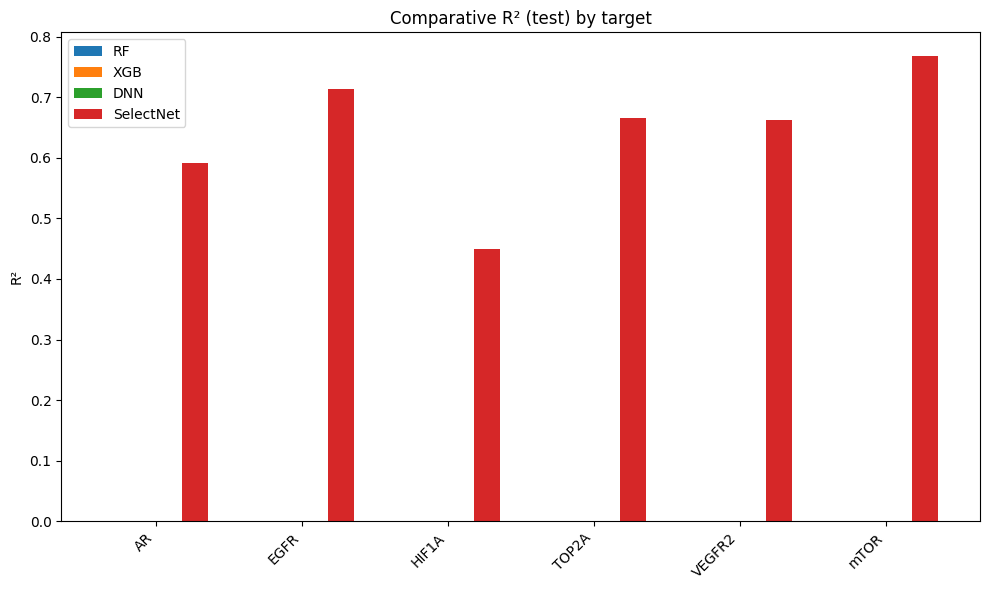

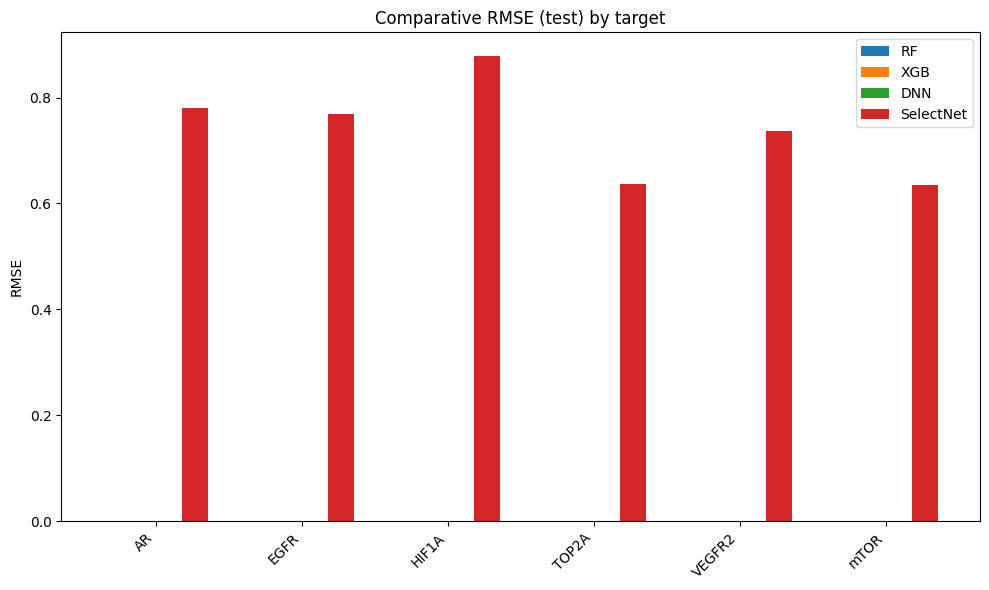

Saved figures → /content/figures/Comparative_R2.png and /content/figures/Comparative_RMSE.png


In [25]:
# ---- Robust aggregator: works even if some CSVs are missing ----
from pathlib import Path
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# Ensure folders exist
ART = Path("./artifacts"); ART.mkdir(parents=True, exist_ok=True)
FIG = Path("./figures");   FIG.mkdir(parents=True, exist_ok=True)

def load_or_empty(path: Path, model_name: str):
    """Load a per-target summary CSV or return an empty frame with the right columns."""
    if path.exists():
        df = pd.read_csv(path)
        # normalize expected column names
        keep = {"Target","R2_test","RMSE_test","N_test"}
        cols = {c.strip():c for c in df.columns}
        miss = keep - set(cols)
        if miss:
            # try lower-case fix
            cols_lower = {c.lower().strip(): c for c in df.columns}
            mapping = {cols_lower.get(k.lower(), None): k for k in keep}
            mapping = {k:v for k,v in mapping.items() if k is not None}
            df = df.rename(columns=mapping)
        return df
    else:
        print(f"⚠️ Missing file for {model_name}: {path}")
        return pd.DataFrame(columns=["Target","R2_test","RMSE_test","N_test"])

rf  = load_or_empty(ART/"rf_ecfp4_summary.csv", "RF")
xgb = load_or_empty(ART/"xgb_ecfp4_summary.csv", "XGB")
dnn = load_or_empty(ART/"dnn_ecfp4_summary.csv", "DNN")
sel = load_or_empty(ART/"selectivitynet_lite_summary.csv", "SelectivityNet")

def pick(df, name):
    df = df[["Target","R2_test","RMSE_test"]].copy()
    df.columns = ["Target", f"{name}_R2", f"{name}_RMSE"]
    return df

# Outer-merge whatever exists
table2 = (pick(rf,"RF")
          .merge(pick(xgb,"XGB"), on="Target", how="outer")
          .merge(pick(dnn,"DNN"), on="Target", how="outer")
          .merge(pick(sel,"SelectNet"), on="Target", how="outer"))

# Save & preview
table2_path = ART/"Table2_Comparative_Performance.csv"
table2.to_csv(table2_path, index=False)
display(table2.head(10))
print(f"Saved Table 2 → {table2_path.resolve()}")

# ---- Plots (R² and RMSE) — handle missing values gracefully ----
targets = list(table2["Target"].fillna("UNK"))
models = ["RF","XGB","DNN","SelectNet"]
x = np.arange(len(targets)); width = 0.18

# R²
plt.figure(figsize=(10,6))
for i, m in enumerate(models):
    col = f"{m}_R2"
    vals = table2[col].astype(float).fillna(0).values if col in table2.columns else np.zeros(len(targets))
    plt.bar(x + i*width - 1.5*width, vals, width, label=m)
plt.xticks(x, targets, rotation=45, ha="right")
plt.ylabel("R²"); plt.title("Comparative R² (test) by target")
plt.legend(); plt.tight_layout()
r2_path = FIG/"Comparative_R2.png"
plt.savefig(r2_path, dpi=300); plt.show()

# RMSE
plt.figure(figsize=(10,6))
for i, m in enumerate(models):
    col = f"{m}_RMSE"
    vals = table2[col].astype(float).fillna(0).values if col in table2.columns else np.zeros(len(targets))
    plt.bar(x + i*width - 1.5*width, vals, width, label=m)
plt.xticks(x, targets, rotation=45, ha="right")
plt.ylabel("RMSE"); plt.title("Comparative RMSE (test) by target")
plt.legend(); plt.tight_layout()
rmse_path = FIG/"Comparative_RMSE.png"
plt.savefig(rmse_path, dpi=300); plt.show()

print(f"Saved figures → {r2_path.resolve()} and {rmse_path.resolve()}")
